In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


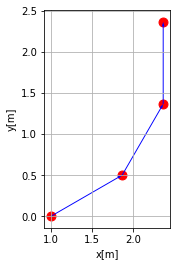

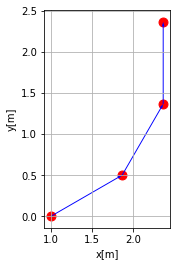

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 5000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_V_STEP = 0.3 / DATA_NUM_WAYPOINTS # [m/step]
DATA_MAX_V_STEP = 0.5 / DATA_NUM_WAYPOINTS # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_NUM_WAYPOINTS # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_NUM_WAYPOINTS # [rad/step]
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :5000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.03
DATA_MAX_V_STEP      :0.05
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

5000
(10, 3)


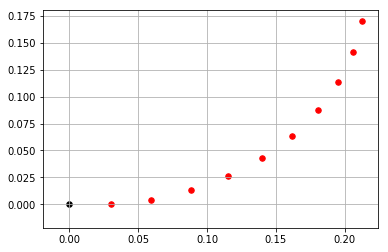

 -- x_train -- 
[[ 2.99718267e-02 -7.28153078e-08 -1.34556890e+00]
 [ 5.96064407e-02  4.48323423e-03 -1.19541890e+00]
 [ 8.82369835e-02  1.33490346e-02 -1.04526890e+00]
 [ 1.15219190e-01  2.63978240e-02 -8.95118897e-01]
 [ 1.39945889e-01  4.33359693e-02 -7.44968897e-01]
 [ 1.61860662e-01  6.37823166e-02 -5.94818897e-01]
 [ 1.80470368e-01  8.72767679e-02 -4.44668897e-01]
 [ 1.95356238e-01  1.13290635e-01 -2.94518897e-01]
 [ 2.06183300e-01  1.41238535e-01 -1.44368897e-01]
 [ 2.12707916e-01  1.70491565e-01  5.78110266e-03]]


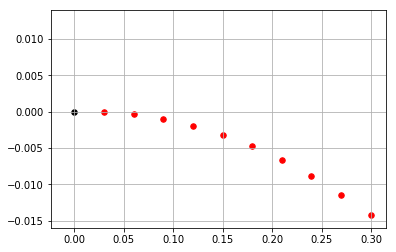

 -- x_train -- 
[[ 2.99998603e-02  5.53403948e-08 -1.58665317e+00]
 [ 5.99980454e-02 -3.16981942e-04 -1.59722317e+00]
 [ 8.99912037e-02 -9.51076425e-04 -1.60779317e+00]
 [ 1.19975984e-01 -1.90215727e-03 -1.61836317e+00]
 [ 1.49949037e-01 -3.17011821e-03 -1.62893317e+00]
 [ 1.79907013e-01 -4.75481759e-03 -1.63950317e+00]
 [ 2.09846566e-01 -6.65607836e-03 -1.65007317e+00]
 [ 2.39764351e-01 -8.87368810e-03 -1.66064317e+00]
 [ 2.69657024e-01 -1.14073991e-02 -1.67121317e+00]
 [ 2.99521247e-01 -1.42569282e-02 -1.68178317e+00]]


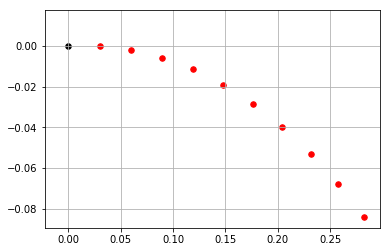

 -- x_train -- 
[[ 2.99948128e-02  1.17687335e-07 -1.66743025e+00]
 [ 5.99274165e-02 -1.93069453e-03 -1.73185025e+00]
 [ 8.96736355e-02 -5.78442667e-03 -1.79627025e+00]
 [ 1.19110068e-01 -1.15450915e-02 -1.86069025e+00]
 [ 1.48114596e-01 -1.91887910e-02 -1.92511025e+00]
 [ 1.76566895e-01 -2.86838151e-02 -1.98953025e+00]
 [ 2.04348930e-01 -3.99907738e-02 -2.05395025e+00]
 [ 2.31345448e-01 -5.30627601e-02 -2.11837025e+00]
 [ 2.57444453e-01 -6.78455449e-02 -2.18279025e+00]
 [ 2.82537674e-01 -8.42778017e-02 -2.24721025e+00]]


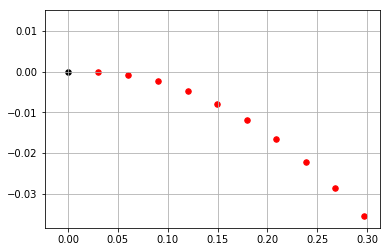

 -- x_train -- 
[[ 2.99991229e-02  2.95086458e-08 -1.61053231e+00]
 [ 5.99877216e-02 -7.94524821e-04 -1.63702231e+00]
 [ 8.99447539e-02 -2.38310547e-03 -1.66351231e+00]
 [ 1.19849200e-01 -4.76459775e-03 -1.69000231e+00]
 [ 1.49680075e-01 -7.93733064e-03 -1.71649231e+00]
 [ 1.79416449e-01 -1.18990779e-02 -1.74298231e+00]
 [ 2.09037456e-01 -1.66470596e-02 -1.76947231e+00]
 [ 2.38522311e-01 -2.21779443e-02 -1.79596231e+00]
 [ 2.67850326e-01 -2.84878509e-02 -1.82245231e+00]
 [ 2.97000921e-01 -3.55723521e-02 -1.84894231e+00]]


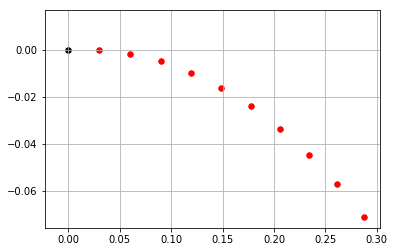

 -- x_train -- 
[[ 2.99963713e-02  1.14474811e-07 -1.65162014e+00]
 [ 5.99492188e-02 -1.61519383e-03 -1.70550014e+00]
 [ 8.97716087e-02 -4.84123672e-03 -1.75938014e+00]
 [ 1.19376986e-01 -9.66865107e-03 -1.81326014e+00]
 [ 1.48679425e-01 -1.60834260e-02 -1.86714014e+00]
 [ 1.77593881e-01 -2.40669437e-02 -1.92102014e+00]
 [ 2.06036433e-01 -3.35960331e-02 -1.97490014e+00]
 [ 2.33924530e-01 -4.46430373e-02 -2.02878014e+00]
 [ 2.61177233e-01 -5.71758942e-02 -2.08266014e+00]
 [ 2.87715443e-01 -7.11582290e-02 -2.13654014e+00]]


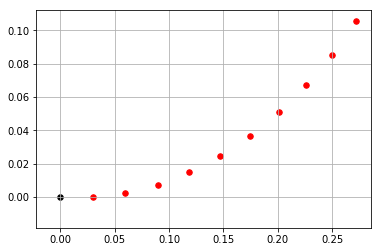

 -- x_train -- 
[[ 2.99915218e-02 -5.48886530e-08 -1.44725450e+00]
 [ 5.98813867e-02  2.46720057e-03 -1.36489450e+00]
 [ 8.94669615e-02  7.38504002e-03 -1.28253450e+00]
 [ 1.18547675e-01  1.47201238e-02 -1.20017450e+00]
 [ 1.46926381e-01  2.44227248e-02 -1.11781450e+00]
 [ 1.74410688e-01  3.64270660e-02 -1.03545450e+00]
 [ 2.00814273e-01  5.06517658e-02 -9.53094497e-01]
 [ 2.25958136e-01  6.70003902e-02 -8.70734497e-01]
 [ 2.49671819e-01  8.53621065e-02 -7.88374497e-01]
 [ 2.71794559e-01  1.05612434e-01 -7.06014497e-01]]


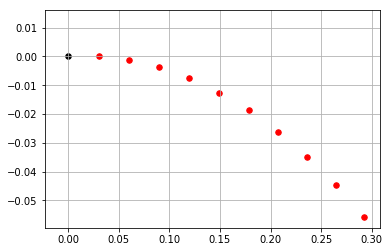

 -- x_train -- 
[[ 2.99978129e-02  9.72237196e-09 -1.63354165e+00]
 [ 5.99693856e-02 -1.25442317e-03 -1.67537165e+00]
 [ 8.98622832e-02 -3.76110407e-03 -1.71720165e+00]
 [ 1.19624208e-01 -7.51564754e-03 -1.75903165e+00]
 [ 1.49203092e-01 -1.25114850e-02 -1.80086165e+00]
 [ 1.78547187e-01 -1.87398764e-02 -1.84269165e+00]
 [ 2.07605156e-01 -2.61899250e-02 -1.88452165e+00]
 [ 2.36326162e-01 -3.48485971e-02 -1.92635165e+00]
 [ 2.64659958e-01 -4.47007444e-02 -1.96818165e+00]
 [ 2.92556973e-01 -5.57291307e-02 -2.01001165e+00]]


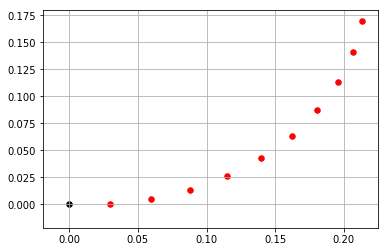

 -- x_train -- 
[[ 2.99720887e-02 -1.21583958e-07 -1.34661727e+00]
 [ 5.96101001e-02  4.46243092e-03 -1.19716727e+00]
 [ 8.82532917e-02  1.32881704e-02 -1.04771727e+00]
 [ 1.15263099e-01  2.62803380e-02 -8.98267270e-01]
 [ 1.40037371e-01  4.31492894e-02 -7.48817270e-01]
 [ 1.62023797e-01  6.35189523e-02 -5.99367270e-01]
 [ 1.80732217e-01  8.69352101e-02 -4.49917270e-01]
 [ 1.95745549e-01  1.12876026e-01 -3.00467270e-01]
 [ 2.06729090e-01  1.40763083e-01 -1.51017270e-01]
 [ 2.13437976e-01  1.69974672e-01 -1.56727022e-03]]


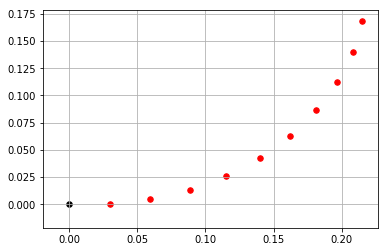

 -- x_train -- 
[[ 2.99726534e-02 -2.61567207e-08 -1.34890045e+00]
 [ 5.96179582e-02  4.41764905e-03 -1.20097045e+00]
 [ 8.82883599e-02  1.31565286e-02 -1.05304045e+00]
 [ 1.15357599e-01  2.60257254e-02 -9.05110454e-01]
 [ 1.40234392e-01  4.27441326e-02 -7.57180454e-01]
 [ 1.62375344e-01  6.29465630e-02 -6.09250454e-01]
 [ 1.81296821e-01  8.61917268e-02 -4.61320454e-01]
 [ 1.96585515e-01  1.11971870e-01 -3.13390454e-01]
 [ 2.07907467e-01  1.39723868e-01 -1.65460454e-01]
 [ 2.15015368e-01  1.68841520e-01 -1.75304541e-02]]


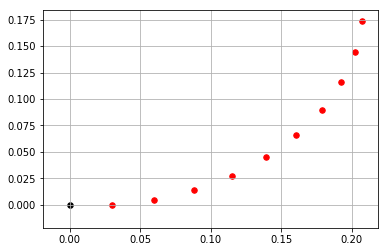

 -- x_train -- 
[[ 2.99698848e-02 -7.88443637e-09 -1.33793606e+00]
 [ 5.95793664e-02  4.63384452e-03 -1.18269606e+00]
 [ 8.81163044e-02  1.37901080e-02 -1.02745606e+00]
 [ 1.14894354e-01  2.72485643e-02 -8.72216064e-01]
 [ 1.39269474e-01  4.46855228e-02 -7.16976064e-01]
 [ 1.60655416e-01  6.56816056e-02 -5.61736064e-01]
 [ 1.78537824e-01  8.97318337e-02 -4.06496064e-01]
 [ 1.92486607e-01  1.16257773e-01 -2.51256064e-01]
 [ 2.02166281e-01  1.44621445e-01 -9.60160637e-02]
 [ 2.07344040e-01  1.74140673e-01  5.92239363e-02]]


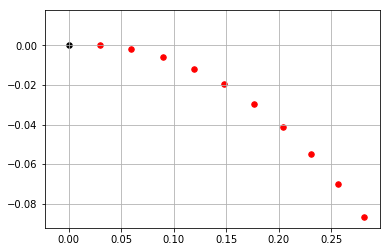

 -- x_train -- 
[[ 2.99944791e-02  1.44009405e-07 -1.67049113e+00]
 [ 5.99227504e-02 -1.99167823e-03 -1.73695113e+00]
 [ 8.96526714e-02 -5.96667222e-03 -1.80341113e+00]
 [ 1.19052975e-01 -1.19072871e-02 -1.86987113e+00]
 [ 1.47993851e-01 -1.97872933e-02 -1.93633113e+00]
 [ 1.76347515e-01 -2.95718982e-02 -2.00279113e+00]
 [ 2.03988779e-01 -4.12178997e-02 -2.06925113e+00]
 [ 2.30795596e-01 -5.46738772e-02 -2.13571113e+00]
 [ 2.56649607e-01 -6.98804184e-02 -2.20217113e+00]
 [ 2.81436658e-01 -8.67703817e-02 -2.26863113e+00]]


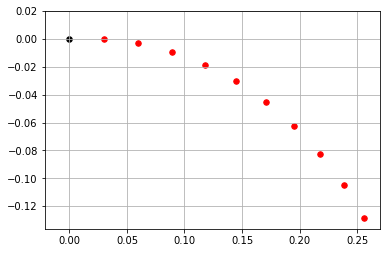

 -- x_train -- 
[[ 2.99866167e-02  1.38105768e-09 -1.72601637e+00]
 [ 5.98128267e-02 -3.09747740e-03 -1.82949637e+00]
 [ 8.91595326e-02 -9.25929777e-03 -1.93297637e+00]
 [ 1.17712767e-01 -1.84195372e-02 -2.03645637e+00]
 [ 1.45167051e-01 -3.04801942e-02 -2.13993637e+00]
 [ 1.71228664e-01 -4.53122372e-02 -2.24341637e+00]
 [ 1.95618785e-01 -6.27569848e-02 -2.34689637e+00]
 [ 2.18076473e-01 -8.26278032e-02 -2.45037637e+00]
 [ 2.38361464e-01 -1.04712103e-01 -2.55385637e+00]
 [ 2.56256738e-01 -1.28773615e-01 -2.65733637e+00]]


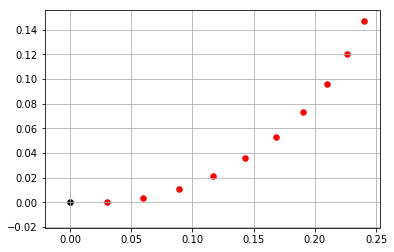

 -- x_train -- 
[[ 2.99813466e-02 -1.44399811e-07 -1.38753651e+00]
 [ 5.97392455e-02  3.65342861e-03 -1.26536651e+00]
 [ 8.88300971e-02  1.09062554e-02 -1.14319651e+00]
 [ 1.16820245e-01  2.16502184e-02 -1.02102651e+00]
 [ 1.43292443e-01  3.57251578e-02 -8.98856510e-01]
 [ 1.67852069e-01  5.29212592e-02 -7.76686510e-01]
 [ 1.90133015e-01  7.29821811e-02 -6.54516510e-01]
 [ 2.09803140e-01  9.56088762e-02 -5.32346510e-01]
 [ 2.26569222e-01  1.20464050e-01 -4.10176510e-01]
 [ 2.40181330e-01  1.47177186e-01 -2.88006510e-01]]


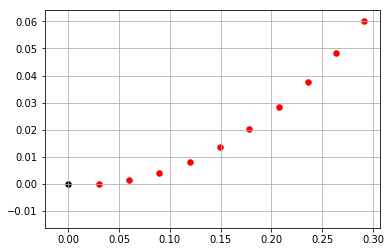

 -- x_train -- 
[[ 2.99974474e-02 -3.51678376e-08 -1.50301015e+00]
 [ 5.99642722e-02  1.35505301e-03 -1.45782015e+00]
 [ 8.98392884e-02  4.06249774e-03 -1.41263015e+00]
 [ 1.19561498e-01  8.11677098e-03 -1.36744015e+00]
 [ 1.49070213e-01  1.35095948e-02 -1.32225015e+00]
 [ 1.78305185e-01  2.02299581e-02 -1.27706015e+00]
 [ 2.07206721e-01  2.82641394e-02 -1.23187015e+00]
 [ 2.35715810e-01  3.75957346e-02 -1.18668015e+00]
 [ 2.63774244e-01  4.82056905e-02 -1.14149015e+00]
 [ 2.91324732e-01  6.00723439e-02 -1.09630015e+00]]


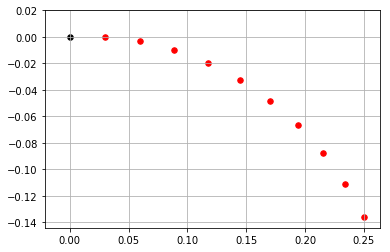

 -- x_train -- 
[[ 2.99846566e-02  1.49768750e-07 -1.73700132e+00]
 [ 5.97854625e-02 -3.31520772e-03 -1.84780132e+00]
 [ 8.90369381e-02 -9.90541263e-03 -1.95860132e+00]
 [ 1.17380341e-01 -1.96896421e-02 -2.06940132e+00]
 [ 1.44468065e-01 -3.25479016e-02 -2.18020132e+00]
 [ 1.69967904e-01 -4.83224963e-02 -2.29100132e+00]
 [ 1.93567126e-01 -6.68199651e-02 -2.40180132e+00]
 [ 2.14976308e-01 -8.78134536e-02 -2.51260132e+00]
 [ 2.33932886e-01 -1.11045496e-01 -2.62340132e+00]
 [ 2.50204374e-01 -1.36231172e-01 -2.73420132e+00]]


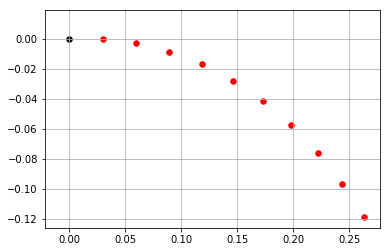

 -- x_train -- 
[[ 2.99888668e-02  1.44290726e-07 -1.71237114e+00]
 [ 5.98442820e-02 -2.82586125e-03 -1.80675114e+00]
 [ 8.93005036e-02 -8.45286241e-03 -1.90113114e+00]
 [ 1.18095342e-01 -1.68307734e-02 -1.99551114e+00]
 [ 1.45972496e-01 -2.78850227e-02 -2.08989114e+00]
 [ 1.72683831e-01 -4.15172166e-02 -2.18427114e+00]
 [ 1.97991590e-01 -5.76060154e-02 -2.27865114e+00]
 [ 2.21670510e-01 -7.60082131e-02 -2.37303114e+00]
 [ 2.43509825e-01 -9.65600122e-02 -2.46741114e+00]
 [ 2.63315145e-01 -1.19078482e-01 -2.56179114e+00]]


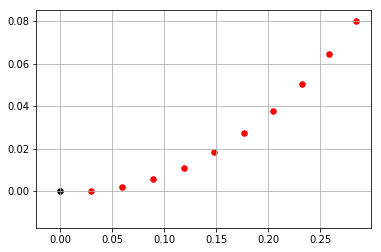

 -- x_train -- 
[[ 2.99953520e-02 -3.61103772e-08 -1.47932512e+00]
 [ 5.99349537e-02  1.82791101e-03 -1.41834512e+00]
 [ 8.97075075e-02  5.47704613e-03 -1.35736512e+00]
 [ 1.19202336e-01  1.09338039e-02 -1.29638512e+00]
 [ 1.48309796e-01  1.81778994e-02 -1.23540512e+00]
 [ 1.76921683e-01  2.71824033e-02 -1.17442512e+00]
 [ 2.04931634e-01  3.79138423e-02 -1.11344512e+00]
 [ 2.32235525e-01  5.03323230e-02 -1.05246512e+00]
 [ 2.58731857e-01  6.43916811e-02 -9.91485123e-01]
 [ 2.84322131e-01  8.00396521e-02 -9.30505123e-01]]


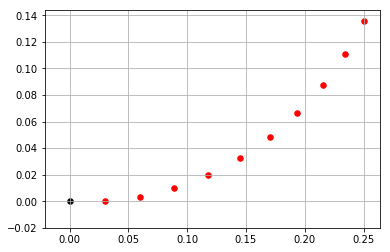

 -- x_train -- 
[[ 2.99847229e-02 -1.41527436e-07 -1.40495161e+00]
 [ 5.97863888e-02  3.30807919e-03 -1.29439161e+00]
 [ 8.90410873e-02  9.88426524e-03 -1.18383161e+00]
 [ 1.17391587e-01  1.96481144e-02 -1.07327161e+00]
 [ 1.44491699e-01  3.24803996e-02 -9.62711607e-01]
 [ 1.70010502e-01  4.82244249e-02 -8.52151607e-01]
 [ 1.93636383e-01  6.66879391e-02 -7.41591607e-01]
 [ 2.15080845e-01  8.76454828e-02 -6.31031607e-01]
 [ 2.34082029e-01  1.10841142e-01 -5.20471607e-01]
 [ 2.50407910e-01  1.35991673e-01 -4.09911607e-01]]


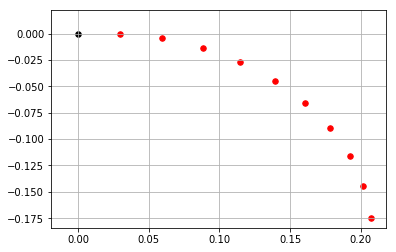

 -- x_train -- 
[[ 2.99697488e-02  1.29207998e-07 -1.80418564e+00]
 [ 5.95774914e-02 -4.64394531e-03 -1.95977564e+00]
 [ 8.81079208e-02 -1.38200253e-02 -2.11536564e+00]
 [ 1.14871758e-01 -2.73064216e-02 -2.27095564e+00]
 [ 1.39222402e-01 -4.47773104e-02 -2.42654564e+00]
 [ 1.60571556e-01 -6.58106046e-02 -2.58213564e+00]
 [ 1.78403436e-01 -8.98981513e-02 -2.73772564e+00]
 [ 1.92287233e-01 -1.16458009e-01 -2.89331564e+00]
 [ 2.01887523e-01 -1.44848505e-01 -3.04890564e+00]
 [ 2.06972367e-01 -1.74383742e-01 -3.20449564e+00]]


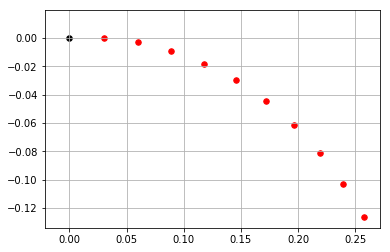

 -- x_train -- 
[[ 2.99871340e-02  9.87745239e-08 -1.72298962e+00]
 [ 5.98200646e-02 -3.03708029e-03 -1.82444962e+00]
 [ 8.91919511e-02 -9.08029887e-03 -1.92590962e+00]
 [ 1.17800695e-01 -1.80674006e-02 -2.02736962e+00]
 [ 1.45352046e-01 -2.99059505e-02 -2.12882962e+00]
 [ 1.71562630e-01 -4.44741855e-02 -2.23028962e+00]
 [ 1.96162864e-01 -6.16222667e-02 -2.33174962e+00]
 [ 2.18899727e-01 -8.11738210e-02 -2.43320962e+00]
 [ 2.39539363e-01 -1.02927755e-01 -2.53466962e+00]
 [ 2.57869487e-01 -1.26660322e-01 -2.63612962e+00]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [8]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    '''
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y_v, y_w = model(x)
            # clip
            v_limit = DATA_MAX_V_STEP
            w_limit = DATA_MAX_W_STEP
            v = F.clip(y_v,-v_limit,v_limit)
            w = F.clip(y_w,-w_limit,w_limit)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
            y_pad = F.stack((v,pad,w),axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 0.13159706
Epoch: 2 , Average loss: 0.034646697
Epoch: 3 , Average loss: 0.033202525
Epoch: 4 , Average loss: 0.032343246
Epoch: 5 , Average loss: 0.032502662
start: 2019/10/15 19:44:38
finish: 2019/10/15 19:58:08


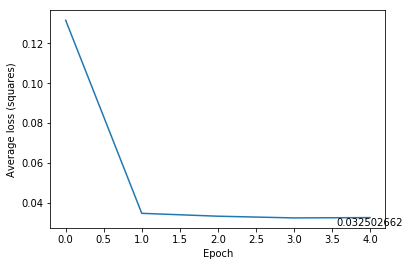

In [10]:
EPOCH = 5
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [18]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    fn = 'Model' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
print(dirname)

Model30mm10step_201910152000_5000data5ep


In [19]:
os.mkdir(dirname)
f = open(dirname+'/params.txt','w')
f.writelines(params)
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 2.99840130e-02 -1.07667182e-07 -1.40114274e+00]
 [ 5.97764707e-02  3.38375205e-03 -1.28804274e+00]
 [ 8.89966855e-02  1.01083403e-02 -1.17494274e+00]
 [ 1.17271282e-01  2.00877303e-02 -1.06184274e+00]
 [ 1.44238968e-01  3.31944057e-02 -9.48742736e-01]
 [ 1.69555151e-01  4.92608897e-02 -8.35642736e-01]
 [ 1.92896342e-01  6.80818850e-02 -7.22542736e-01]
 [ 2.13964286e-01  8.94168973e-02 -6.09442736e-01]
 [ 2.32489779e-01  1.12993308e-01 -4.96342736e-01]
 [ 2.48236102e-01  1.38509859e-01 -3.83242736e-01]]
 --- output --- 
[[[ 0.02974398  0.          0.10994651]
  [ 0.03008951  0.          0.10927239]
  [ 0.02954907  0.          0.11086136]
  [ 0.03097742  0.          0.10123719]
  [ 0.02059888  0.          0.12223868]
  [ 0.05        0.          0.10700192]
  [ 0.01952483  0.          0.11487999]
  [ 0.02915849  0.          0.11476245]
  [ 0.02906995  0.          0.11046088]
  [ 0.02901652  0.         -0.14184113]]]
 --- error --- 
e_distance: variable(0.03455234)	e_dw:

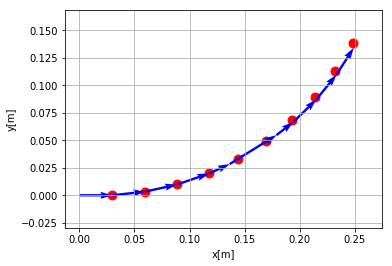

 --- grad --- 
variable([[-0.0021016   0.42332608  0.781815    1.1826943   0.14532745
            0.         -0.746631   -1.2324919  -1.1637938  -0.7020558 ]])
variable([[-0.94626117 -0.7879974  -0.64264834 -0.4982134  -0.41726378
           -0.22153535 -0.14693362 -0.06787065 -0.0206633   0.        ]])
variable([[-1.342445   -3.1203065   0.69710547 -1.4663845   0.6302415
           -0.96694595  3.161764   -2.862791    0.49104324 -1.311161
           -0.38744617 -1.5505476  -0.10549885 -1.336136    0.0240531
           -0.2573446   0.81720185 -1.4381756  -1.2045711  -0.32932535]])


In [15]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y_v,y_w = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,-v_limit,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
# print(' --- trajectory --- ')
# print(Z)
# print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
v_grad = chainer.grad( (loss,), (y_v,) )[0]
print(v_grad)
w_grad = chainer.grad( (loss,), (y_w,) )[0]
print(w_grad)
x_grad = chainer.grad( (loss,), (x,) )[0]
print(x_grad)

 --- input --- 
[[ 2.99916141e-02 -1.11921356e-07 -1.44792760e+00]
 [ 5.98826831e-02  2.45364356e-03 -1.36601760e+00]
 [ 8.94727724e-02  7.34481280e-03 -1.28410760e+00]
 [ 1.18563466e-01  1.46405981e-02 -1.20219760e+00]
 [ 1.46959695e-01  2.42920775e-02 -1.12028760e+00]
 [ 1.74471051e-01  3.62345331e-02 -1.03837760e+00]
 [ 2.00913054e-01  5.03878848e-02 -9.56467595e-01]
 [ 2.26108399e-01  6.66572273e-02 -8.74557595e-01]
 [ 2.49888139e-01  8.49334666e-02 -7.92647595e-01]
 [ 2.72092817e-01  1.05094051e-01 -7.10737595e-01]]
 --- output --- 
[[[ 0.02975537  0.          0.07345299]
  [ 0.03006766  0.          0.08634564]
  [ 0.02968695  0.          0.08189854]
  [ 0.03075087  0.          0.06260827]
  [ 0.02623804  0.          0.09825825]
  [ 0.05        0.          0.06727813]
  [ 0.01387317  0.          0.08062197]
  [ 0.02935863  0.          0.08171356]
  [ 0.02920862  0.          0.08336797]
  [ 0.02904331  0.         -0.12348907]]]
 --- error --- 
loss: variable(0.00023625)
loss: varia

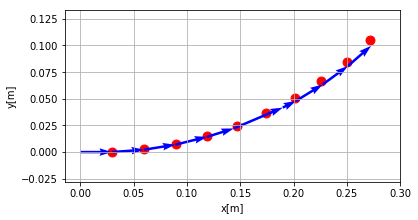

 --- input --- 
[[ 2.99774863e-02  1.13930743e-07 -1.77213013e+00]
 [ 5.96853707e-02 -4.01128145e-03 -1.90635013e+00]
 [ 8.85892682e-02 -1.19620293e-02 -2.04057013e+00]
 [ 1.16169256e-01 -2.37091116e-02 -2.17479013e+00]
 [ 1.41929227e-01 -3.90412222e-02 -2.30901013e+00]
 [ 1.65405809e-01 -5.76825673e-02 -2.44323013e+00]
 [ 1.86176708e-01 -7.92978269e-02 -2.57745013e+00]
 [ 2.03868297e-01 -1.03498186e-01 -2.71167013e+00]
 [ 2.18162339e-01 -1.29848329e-01 -2.84589013e+00]
 [ 2.28801714e-01 -1.57874270e-01 -2.98011013e+00]]
 --- output --- 
[[[ 0.02971694  0.         -0.13317326]
  [ 0.03000073  0.         -0.13731095]
  [ 0.0300038   0.         -0.1377749 ]
  [ 0.03051023  0.         -0.12586091]
  [ 0.0169431   0.         -0.1383241 ]
  [ 0.05        0.         -0.14047457]
  [ 0.02272593  0.         -0.13662244]
  [ 0.02977449  0.         -0.13174918]
  [ 0.02982672  0.         -0.13727804]
  [ 0.02923109  0.          0.02090639]]]
 --- error --- 
loss: variable(0.00026055)
loss: varia

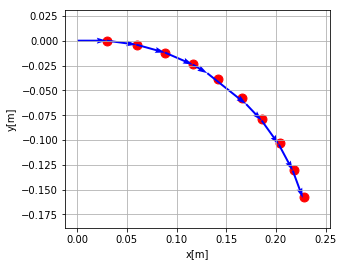

 --- input --- 
[[ 2.99980596e-02 -1.30767314e-08 -1.51169589e+00]
 [ 5.99728388e-02  1.18159163e-03 -1.47229589e+00]
 [ 8.98778120e-02  3.54298009e-03 -1.43289589e+00]
 [ 1.19666562e-01  7.08048705e-03 -1.39349589e+00]
 [ 1.49292852e-01  1.17886217e-02 -1.35409589e+00]
 [ 1.78710697e-01  1.76600763e-02 -1.31469589e+00]
 [ 2.07874436e-01  2.46857375e-02 -1.27529589e+00]
 [ 2.36738802e-01  3.28547002e-02 -1.23589589e+00]
 [ 2.65258993e-01  4.21542850e-02 -1.19649589e+00]
 [ 2.93390741e-01  5.25700573e-02 -1.15709589e+00]]
 --- output --- 
[[[ 0.02975576  0.          0.03025009]
  [ 0.03004882  0.          0.04692913]
  [ 0.02979115  0.          0.04031846]
  [ 0.03061784  0.          0.02084744]
  [ 0.02748924  0.          0.05671674]
  [ 0.05        0.          0.02247138]
  [ 0.01255702  0.          0.03701444]
  [ 0.02950188  0.          0.03914941]
  [ 0.02935136  0.          0.04249465]
  [ 0.02907839  0.         -0.09662569]]]
 --- error --- 
loss: variable(0.0002423)
loss: variab

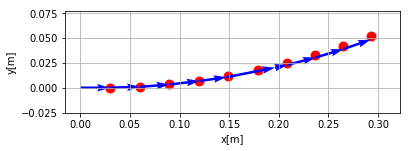

 --- input --- 
[[ 2.99929411e-02  6.44593583e-08 -1.68352348e+00]
 [ 5.99012340e-02 -2.25171983e-03 -1.75867348e+00]
 [ 8.95560504e-02 -6.74264184e-03 -1.83382348e+00]
 [ 1.18789993e-01 -1.34473509e-02 -1.90897348e+00]
 [ 1.47438040e-01 -2.23279999e-02 -1.98412348e+00]
 [ 1.75338477e-01 -3.33344588e-02 -2.05927348e+00]
 [ 2.02333809e-01 -4.64045975e-02 -2.13442348e+00]
 [ 2.28271653e-01 -6.14646368e-02 -2.20957348e+00]
 [ 2.53005592e-01 -7.84295650e-02 -2.28472348e+00]
 [ 2.76396006e-01 -9.72036173e-02 -2.35987348e+00]]
 --- output --- 
[[[ 0.029725    0.         -0.07993898]
  [ 0.03002173  0.         -0.07727534]
  [ 0.02991006  0.         -0.07972713]
  [ 0.03056914  0.         -0.07802635]
  [ 0.02041913  0.         -0.07479452]
  [ 0.05        0.         -0.08740601]
  [ 0.01938871  0.         -0.08002555]
  [ 0.02967387  0.         -0.07600614]
  [ 0.02966059  0.         -0.07869925]
  [ 0.02919437  0.         -0.01777193]]]
 --- error --- 
loss: variable(0.00026794)
loss: varia

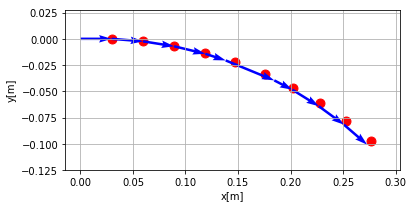

 --- input --- 
[[ 2.99991866e-02  7.61007570e-08 -1.60906386e+00]
 [ 5.99886144e-02 -7.65044073e-04 -1.63457386e+00]
 [ 8.99487688e-02 -2.29486264e-03 -1.66008386e+00]
 [ 1.19860154e-01 -4.58838410e-03 -1.68559386e+00]
 [ 1.49703305e-01 -7.64411602e-03 -1.71110386e+00]
 [ 1.79458804e-01 -1.14600699e-02 -1.73661386e+00]
 [ 2.09107287e-01 -1.60337627e-02 -1.76212386e+00]
 [ 2.38629461e-01 -2.13622182e-02 -1.78763386e+00]
 [ 2.68006115e-01 -2.74419689e-02 -1.81314386e+00]
 [ 2.97218134e-01 -3.42690588e-02 -1.83865386e+00]]
 --- output --- 
[[[ 0.02973898  0.         -0.03174039]
  [ 0.03003304  0.         -0.02292577]
  [ 0.0298605   0.         -0.0272136 ]
  [ 0.03058797  0.         -0.03477952]
  [ 0.02351544  0.         -0.01722299]
  [ 0.05        0.         -0.03936984]
  [ 0.01639585  0.         -0.02883043]
  [ 0.0295997   0.         -0.02562471]
  [ 0.02952618  0.         -0.02567615]
  [ 0.02914214  0.         -0.05240358]]]
 --- error --- 
loss: variable(0.00026021)
loss: varia

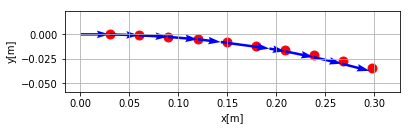

 --- input --- 
[[ 2.99757189e-02 -8.15399342e-08 -1.36170861e+00]
 [ 5.96607127e-02  4.16463583e-03 -1.22231861e+00]
 [ 8.84791478e-02  1.24133644e-02 -1.08292861e+00]
 [ 1.15872000e-01  2.45860941e-02 -9.43538607e-01]
 [ 1.41307900e-01  4.04466969e-02 -8.04148607e-01]
 [ 1.64293439e-01  5.96875066e-02 -6.64758607e-01]
 [ 1.84382739e-01  8.19352874e-02 -5.25368607e-01]
 [ 2.01186106e-01  1.06758474e-01 -3.85978607e-01]
 [ 2.14377585e-01  1.33675543e-01 -2.46588607e-01]
 [ 2.23701288e-01  1.62164353e-01 -1.07198607e-01]]
 --- output --- 
[[[ 0.02974341  0.          0.13730021]
  [ 0.03009702  0.          0.12641054]
  [ 0.02948627  0.          0.13248338]
  [ 0.031108    0.          0.1301872 ]
  [ 0.01629866  0.          0.14020245]
  [ 0.05        0.          0.13671441]
  [ 0.02380821  0.          0.14046341]
  [ 0.02902653  0.          0.13943134]
  [ 0.02898288  0.          0.13071844]
  [ 0.02897326  0.         -0.1555512 ]]]
 --- error --- 
loss: variable(0.00023231)
loss: varia

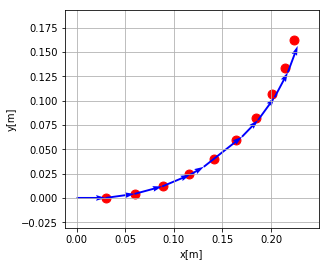

 --- input --- 
[[ 2.99955986e-02  1.06575858e-07 -1.65980988e+00]
 [ 5.99384083e-02 -1.77868145e-03 -1.71914988e+00]
 [ 8.97230243e-02 -5.33010237e-03 -1.77848988e+00]
 [ 1.19244599e-01 -1.06416545e-02 -1.83782988e+00]
 [ 1.48399209e-01 -1.76946400e-02 -1.89716988e+00]
 [ 1.77084227e-01 -2.64642311e-02 -1.95650988e+00]
 [ 2.05198673e-01 -3.69195569e-02 -2.01584988e+00]
 [ 2.32643580e-01 -4.90238127e-02 -2.07518988e+00]
 [ 2.59322337e-01 -6.27343889e-02 -2.13452988e+00]
 [ 2.85141027e-01 -7.80030216e-02 -2.19386988e+00]]
 --- output --- 
[[[ 0.02972932  0.         -0.06475136]
  [ 0.03002541  0.         -0.06014964]
  [ 0.02989391  0.         -0.06318031]
  [ 0.03057558  0.         -0.0643962 ]
  [ 0.02139709  0.         -0.05665356]
  [ 0.05        0.         -0.0722726 ]
  [ 0.01844379  0.         -0.0638939 ]
  [ 0.02965022  0.         -0.06012815]
  [ 0.02961794  0.         -0.06199187]
  [ 0.02917816  0.         -0.02871515]]]
 --- error --- 
loss: variable(0.00026628)
loss: varia

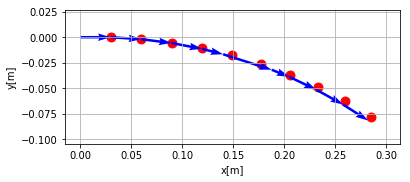

 --- input --- 
[[ 2.99885556e-02 -3.97106451e-08 -1.42726000e+00]
 [ 5.98399235e-02  2.86514836e-03 -1.33157000e+00]
 [ 8.92809758e-02  8.56934890e-03 -1.23588000e+00]
 [ 1.18042339e-01  1.70603708e-02 -1.14019000e+00]
 [ 1.45860858e-01  2.82605247e-02 -1.04450000e+00]
 [ 1.72482006e-01  4.20673338e-02 -9.48810003e-01]
 [ 1.97662209e-01  5.83544714e-02 -8.53120003e-01]
 [ 2.21171078e-01  7.69729168e-02 -7.57430003e-01]
 [ 2.42793518e-01  9.77523189e-02 -6.61740003e-01]
 [ 2.62331692e-01  1.20502555e-01 -5.66050003e-01]]
 --- output --- 
[[[ 0.02974916  0.          0.09008862]
  [ 0.03007875  0.          0.0968018 ]
  [ 0.02961894  0.          0.09511206]
  [ 0.03085912  0.          0.08021698]
  [ 0.02367763  0.          0.10919075]
  [ 0.05        0.          0.08539405]
  [ 0.0164427   0.          0.09625107]
  [ 0.02926512  0.          0.09679244]
  [ 0.02914327  0.          0.09572413]
  [ 0.02903406  0.         -0.13186066]]]
 --- error --- 
loss: variable(0.00023939)
loss: varia

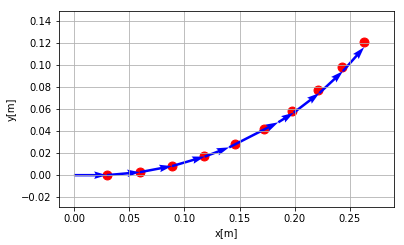

 --- input --- 
[[ 2.99893174e-02 -1.19379183e-07 -1.43211735e+00]
 [ 5.98505777e-02  2.76832639e-03 -1.33966735e+00]
 [ 8.93287383e-02  8.28169223e-03 -1.24721735e+00]
 [ 1.18172029e-01  1.64928890e-02 -1.15476735e+00]
 [ 1.46134101e-01  2.73317854e-02 -1.06231735e+00]
 [ 1.72976133e-01  4.07058075e-02 -9.69867346e-01]
 [ 1.98468870e-01  5.65007288e-02 -8.77417346e-01]
 [ 2.22394579e-01  7.45816462e-02 -7.84967346e-01]
 [ 2.44548915e-01  9.47941321e-02 -6.92517346e-01]
 [ 2.64742657e-01  1.16965553e-01 -6.00067346e-01]]
 --- output --- 
[[[ 0.02975047  0.          0.08624642]
  [ 0.03007633  0.          0.0943874 ]
  [ 0.02963401  0.          0.0920616 ]
  [ 0.03083473  0.          0.07614991]
  [ 0.02427031  0.          0.1066659 ]
  [ 0.05        0.          0.08121089]
  [ 0.01584836  0.          0.09264295]
  [ 0.02928644  0.          0.09331153]
  [ 0.02915811  0.          0.09287103]
  [ 0.02903656  0.         -0.12992789]]]
 --- error --- 
loss: variable(0.00023885)
loss: varia

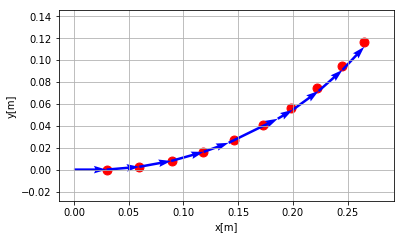

 --- input --- 
[[ 2.99994623e-02  1.39749677e-07 -1.60191099e+00]
 [ 5.99924757e-02 -6.21864775e-04 -1.62265099e+00]
 [ 8.99661391e-02 -1.86574603e-03 -1.64339099e+00]
 [ 1.19907560e-01 -3.73096898e-03 -1.66413099e+00]
 [ 1.49803859e-01 -6.21673133e-03 -1.68487099e+00]
 [ 1.79642178e-01 -9.32196389e-03 -1.70561099e+00]
 [ 2.09409682e-01 -1.30453310e-02 -1.72635099e+00]
 [ 2.39093567e-01 -1.73852311e-02 -1.74709099e+00]
 [ 2.68681064e-01 -2.23397974e-02 -1.76783099e+00]
 [ 2.98159448e-01 -2.79068989e-02 -1.78857099e+00]]
 --- output --- 
[[[ 0.0297403   0.         -0.0270746 ]
  [ 0.03003416  0.         -0.01766493]
  [ 0.0298556   0.         -0.02212967]
  [ 0.03058991  0.         -0.03059376]
  [ 0.0238145   0.         -0.01165131]
  [ 0.05        0.         -0.03471778]
  [ 0.01610681  0.         -0.02387412]
  [ 0.02959249  0.         -0.02074826]
  [ 0.02951315  0.         -0.02054328]
  [ 0.02913716  0.         -0.05574268]]]
 --- error --- 
loss: variable(0.00025916)
loss: varia

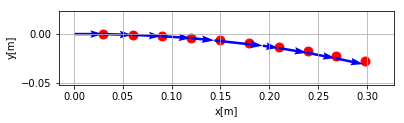

In [17]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y_v,y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,-v_limit,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    fig.savefig(dirname + '/test' + str(i) + '.png')